In [18]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import serial
import time

In [19]:
# Defining the serial COM
SerialObj = serial.Serial('/dev/ttyACM0')

SerialObj.baudrate = 115200
SerialObj.bytesize = 8
time.sleep(3)

In [20]:
#Defining constants
NUM_CLASS = 2
IMAGE_SIZE = (400, 400)
BATCH_SIZE = 32

In [21]:
# Load training data
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        img = cv2.resize(img, IMAGE_SIZE)  # Resize images to a consistent size
        images.append(img)
        labels.append(path.split('/')[-1])  # Assuming the label is the name of the directory
    return images, labels

def test_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)  # Resize image to match training data size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    if np.argmax(prediction) == 0:
        print("Detected object: Apple")
    else:
        print("Detected object: Banana")

In [22]:
# Paths for the train data and the test data
apple_path = "/home/joe/Indvidual Project/data new/Train/Apple"
banana_path = "/home/joe/Indvidual Project/data new/Train/Banana"
test_path = "/home/joe/Indvidual Project/data new/Test"

In [23]:
# Load training data
apple_images, apple_labels = load_data(apple_path)
banana_images, banana_labels = load_data(banana_path)

# Combine data and labels
images = np.array(apple_images + banana_images)
labels = np.array(apple_labels + banana_labels)

label_dict = {'Apple': 0, 'Banana': 1}
labels = np.array([label_dict[label] for label in labels])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [24]:
# The CNN model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

In [25]:
# Chossing the optmizer for the model and compiling it
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
# Saving the best model based on validation accuracy

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=None)

# Print test accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)



Epoch 1/35


5/5 [==============================] - 25s 5s/step - loss: 34.2169 - accuracy: 0.5573 - val_loss: 0.7237 - val_accuracy: 0.5152
Epoch 2/35
5/5 [==============================] - 24s 5s/step - loss: 3.2427 - accuracy: 0.5878 - val_loss: 0.5089 - val_accuracy: 0.7576
Epoch 3/35
5/5 [==============================] - 24s 5s/step - loss: 0.5857 - accuracy: 0.7939 - val_loss: 0.5514 - val_accuracy: 0.8485
Epoch 4/35
5/5 [==============================] - 24s 5s/step - loss: 0.5757 - accuracy: 0.8702 - val_loss: 0.4187 - val_accuracy: 0.9394
Epoch 5/35
5/5 [==============================] - 24s 5s/step - loss: 0.4103 - accuracy: 0.9008 - val_loss: 16.0528 - val_accuracy: 0.5455
Epoch 6/35
5/5 [==============================] - 24s 5s/step - loss: 4.3246 - accuracy: 0.6947 - val_loss: 1.5433 - val_accuracy: 0.6364
Epoch 7/35
5/5 [==============================] - 24s 5s/step - loss: 1.4618 - accuracy: 0.6718 - val_loss: 0.3909 - val_accuracy: 0.8485
Epoch 8/35
5/5 [===========================

In [27]:
# Camera Code to capture the photo for testing
import cv2
import os
import time

def capture_and_save_image(folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Open the default camera (usually 0)
    cap = cv2.VideoCapture(0)

    # Check if the camera is opened successfully
    if not cap.isOpened():
        print("Error: Unable to open camera")
        return

    # Allow the camera to adjust to the lighting conditions (1-second delay)
    time.sleep(1)

    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the captured frame
    cv2.imshow('Captured Image', frame)
    
    # Save the image to the specified folder path
    image_path = os.path.join(folder_path, 'captured_image.jpg')
    cv2.imwrite(image_path, frame)
    
    print("Image saved successfully at:", image_path)

    # Release the camera and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

# Specify the folder path where the image will be saved
folder_path = r"/home/joe/Indvidual Project/data new/Test"

# Call the function to capture and save the image
capture_and_save_image(folder_path)


Image saved successfully at: C:/Users/zuzz4/OneDrive/Desktop/data new/Test/captured_image.jpg


In [28]:
# Load test images
test_dataset_path = "/home/joe/Indvidual Project/data new/Test"
test_images = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_path,
    labels=None,
    color_mode='rgb',
    label_mode=None,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 1 files belonging to 1 classes.


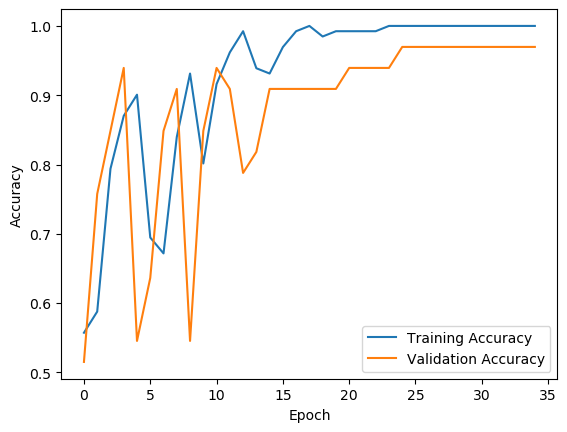

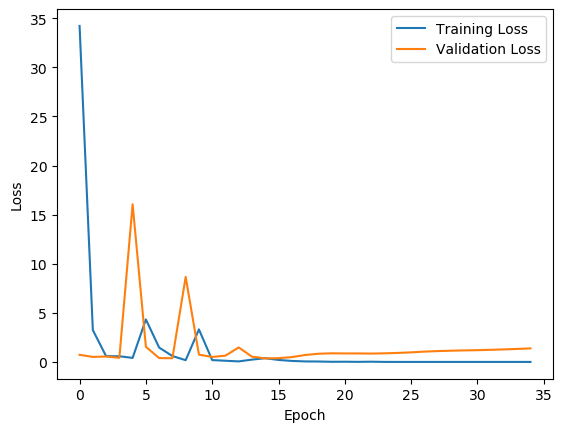

In [29]:
# Plotting Cell
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Make predictions on test images
print("\nPredictions on test images:")
for images in test_images:
    result = model.predict(images)
    print(result)


Predictions on test images:
1/1 [==============================] - 1s 563ms/step
[[1.5374581e-14 1.0000000e+00]]


In [31]:
# Control for the ServoMotors
if (result[0][0] >= 0.7) and  (result[0][1] <= 0.5) :
    SerialObj.write(b'1')
elif (result[0][1] >= 0.7) and  (result[0][0] <= 0.5):
    SerialObj.write(b'2')
       